In [12]:
import matplotlib.pyplot as plt
from torchvision.datasets import EMNIST

In [16]:
from torchvision import transforms
from torchvision.transforms import functional

train_transform = transforms.Compose([
    lambda img: functional.rotate(img, -90),
    lambda img: functional.hflip(img),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    lambda img: functional.rotate(img, -90),
    lambda img: functional.hflip(img),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = EMNIST(root='./Dataset', split='byclass', train=True, download=True, transform=train_transform)
val_dataset = EMNIST(root='./Dataset', split='byclass', train=False, download=True, transform=test_transform)

In [18]:
train_dataset

Dataset EMNIST
    Number of datapoints: 697932
    Root location: ./Dataset
    Split: Train
    StandardTransform
Transform: Compose(
               <function <lambda> at 0x7fa1efcef9d0>
               <function <lambda> at 0x7fa1efcef0d0>
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [19]:
val_dataset

Dataset EMNIST
    Number of datapoints: 116323
    Root location: ./Dataset
    Split: Test
    StandardTransform
Transform: Compose(
               <function <lambda> at 0x7fa1efcef940>
               <function <lambda> at 0x7fa1efcef8b0>
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

# train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42, shuffle=True, stratify=train_dataset.targets)

In [21]:
# train_dataset = Subset(train_dataset, train_idx)
# val_dataset = Subset(train_dataset, val_idx)

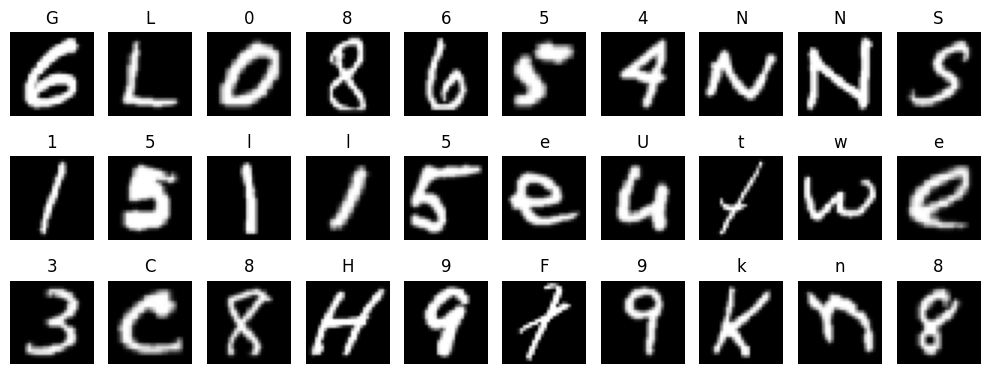

In [23]:
def show_images(imgs, labels):
    fig, axes = plt.subplots(len(imgs)//10, 10, figsize=(10, len(imgs)//10 + 1))
    for i, (img, label) in enumerate(zip(imgs, labels)):
        ax = axes[i//10, i%10]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(train_dataset.classes[label])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

indices = np.random.choice(len(train_dataset), 30)
show_images([train_dataset[i][0] for i in indices], [train_dataset[i][1] for i in indices])

In [24]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [26]:
len(train_loader)

2727

In [27]:
len(val_loader)

455

In [28]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F

class HandWriteClassifier(nn.Module):
    def __init__(self):
        """
        input size : [bs, 1, 28, 28]
        """
        super().__init__()
        self.dropout_rate = 0.25
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)     # [bs, 32, 28, 28]
        self.dropout1 = nn.Dropout2d(self.dropout_rate)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)   # [bs, 64, 28, 28]
        self.dropout2 = nn.Dropout2d(self.dropout_rate)
        self.avgpool1 = nn.AvgPool2d(2)                 # [bs, 64, 14, 14]
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)  # [bs, 128, 14, 14]
        self.dropout3 = nn.Dropout2d(self.dropout_rate)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # [bs, 256, 14, 14]
        self.dropout4 = nn.Dropout2d(self.dropout_rate)
        self.avgpool2 = nn.AvgPool2d(2)                 # [bs, 256, 7, 7]

        self.flatten = nn.Flatten()                     # [bs, 256*7*7]
        self.fc1 = nn.Linear(256*7*7, 512)
        self.dropout5 = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout6 = nn.Dropout(self.dropout_rate)
        self.fc3 = nn.Linear(256, 62)

    def forward(self, x):
        x = self.dropout1(F.relu(self.conv1(x)))
        x = self.dropout2(F.relu(self.conv2(x)))
        x = self.avgpool1(x)
        x = self.dropout3(F.relu(self.conv3(x)))
        x = self.dropout4(F.relu(self.conv4(x)))
        x = self.avgpool2(x)
        x = self.flatten(x)
        x = self.dropout5(F.relu(self.fc1(x)))
        x = self.dropout6(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [29]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
model = HandWriteClassifier().to(device)

lr = 1e-3
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=lr)
scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [30]:
losses_train = []
losses_val = []
accs_train = []
accs_val = []

for epoch in range(epochs):
    model.train()
    loss_train = 0
    acc_train = 0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        acc_train += (y_pred.argmax(1) == y).float().mean().item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}] Step [{i+1}/{len(train_loader)}] LR: {scheduler.get_lr()[0]} Loss_train: {loss.item():.4f}')

    scheduler.step()
    loss_train /= len(train_loader)
    acc_train /= len(train_loader)
    losses_train.append(loss_train)
    accs_train.append(acc_train)

    model.eval()
    loss_val = 0
    acc_val = 0
    with th.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with th.no_grad():
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss_val += loss.item()
                acc_val += (y_pred.argmax(1) == y).float().mean().item()
        loss_val /= len(val_loader)
        acc_val /= len(val_loader)
        losses_val.append(loss_val)
        accs_val.append(acc_val)

    print(f'Epoch {epoch+1}/{epochs}, loss_train: {loss_train:.4f}, loss_val: {loss_val:.4f}, acc_train: {acc_train:.4f}, acc_val: {acc_val:.4f}')

/home/bluesun/anaconda3/envs/rl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch [1/5] Step [100/2727] LR: 0.001 Loss_train: 0.9972
Epoch [1/5] Step [200/2727] LR: 0.001 Loss_train: 0.6988
Epoch [1/5] Step [300/2727] LR: 0.001 Loss_train: 0.6955
Epoch [1/5] Step [400/2727] LR: 0.001 Loss_train: 0.6177
Epoch [1/5] Step [500/2727] LR: 0.001 Loss_train: 0.5030
Epoch [1/5] Step [600/2727] LR: 0.001 Loss_train: 0.6414
Epoch [1/5] Step [700/2727] LR: 0.001 Loss_train: 0.5976
Epoch [1/5] Step [800/2727] LR: 0.001 Loss_train: 0.5711
Epoch [1/5] Step [900/2727] LR: 0.001 Loss_train: 0.4878
Epoch [1/5] Step [1000/2727] LR: 0.001 Loss_train: 0.5214
Epoch [1/5] Step [1100/2727] LR: 0.001 Loss_train: 0.5173
Epoch [1/5] Step [1200/2727] LR: 0.001 Loss_train: 0.4530
Epoch [1/5] Step [1300/2727] LR: 0.001 Loss_train: 0.4226
Epoch [1/5] Step [1400/2727] LR: 0.001 Loss_train: 0.4200
Epoch [1/5] Step [1500/2727] LR: 0.001 Loss_train: 0.4741
Epoch [1/5] Step [1600/2727] LR: 0.001 Loss_train: 0.4740
Epoch [1/5] Step [1700/2727] LR: 0.001 Loss_train: 0.4572
Epoch [1/5] Step [1800/

KeyboardInterrupt: 